In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import collections
import numpy as np
import operator
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters
from pyhive import hive
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from statistics import mean 
from scipy.integrate import quad
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from modules.ModellingBasis import ModellingBasis
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.misc import derivative

In [2]:
#defining constant variables
fTag = "flowvalue"
sTag = "speedvalue"
dTag = "measurementdatetime"
niTag = "ninputs"
sdTag = "sdeviation"
kTag = "density"
fitDegree = 16

In [3]:
reference = "RWS01_MONIBAS_0271hrl0778ra" 
datesList = [("2019-11-26 00:00:00.0", "2019-11-30 00:00:00.0"), ("2019-12-02 00:00:00.0", "2019-12-06 00:00:00.0"), ("2019-12-10 00:00:00.0", "2019-12-11 00:00:00.0"), ("2019-12-19 00:00:00.0", "2019-12-21 00:00:00.0"), ("2019-12-23 00:00:00.0", "2019-12-25 00:00:00.0"), ("2019-12-02 00:00:00.0", "2019-12-06 00:00:00.0"), ("2019-12-10 00:00:00.0", "2019-12-11 00:00:00.0"), ("2019-12-19 00:00:00.0", "2019-12-21 00:00:00.0"), ("2020-01-02 00:00:00.0", "2020-01-04 00:00:00.0"), ("2020-01-14 00:00:00.0", "2020-01-18 00:00:00.0"), ("2020-01-20 00:00:00.0", "2020-01-25 00:00:00.0"), ("2020-01-27 00:00:00.0", "2020-02-01 00:00:00.0"), ("2020-02-03 00:00:00.0", "2020-02-08 00:00:00.0"), ("2020-02-10 00:00:00.0", "2020-02-15 00:00:00.0"), ("2020-02-17 00:00:00.0", "2020-02-20 00:00:00.0")]

In [4]:
#database connection
conn = hive.Connection(host="192.168.1.241", port=10000, username="hive")

#use command
cursor = conn.cursor()
cursor.execute("use RoadNetwork")

#generating sql statements 
sql = "SELECT measurementdatetime, flowvalue, speedvalue FROM MeasurementPoint WHERE"
for i in datesList:
    startDate = i[0]
    endDate = i[1]
    sql = sql + " reference = '" + reference + "' AND measurementdatetime > '" + startDate + "' AND measurementdatetime < '" + endDate + "' OR"
sql = sql[:-3]
sql = sql + " order by measurementdatetime"

#reading data set from database
rawData = pd.read_sql(sql, conn)

In [5]:
mb = ModellingBasis(rawData)

/home/oem/Templates/InternshipMMGuide/Analysis/modules/Cleaner.py:61: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  flowSeries.set_value(index, fTag, flowMean2)
/home/oem/Templates/InternshipMMGuide/Analysis/modules/Cleaner.py:59: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  flowSeries.set_value(index, fTag, flowMean3)
/home/oem/Templates/InternshipMMGuide/Analysis/modules/Cleaner.py:63: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  flowSeries.set_value(index, fTag, flowMean1)
/home/oem/Templates/InternshipMMGuide/Analysis/modules/Cleaner.py:74: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  speedSeries.set_value(index, sTag, speedMean)
/home/oem/anaconda3/lib/python3

In [6]:
flowDF = mb.flowDF
speedDF = mb.speedDF
densityL = mb.densityList

# Flow model

In [7]:
flow_model = mb.flow_model

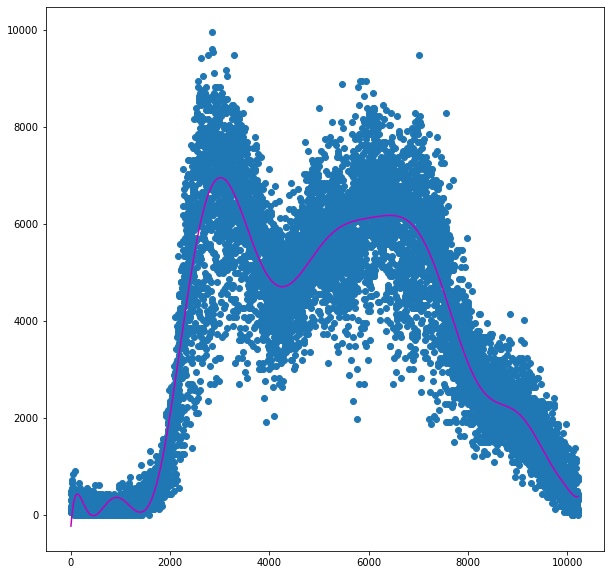

In [8]:
flow_y = np.array(flowDF.iloc[:, 1])
flow_x = np.array(range(len(flowDF)))
plt.scatter(flow_x, flow_y)
plt.plot(flow_model(flow_x), color = 'm')
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

In [9]:
print(mb.flow_model_r2)

0.8833190133755228


# Density model

In [10]:
density_model = mb.density_model

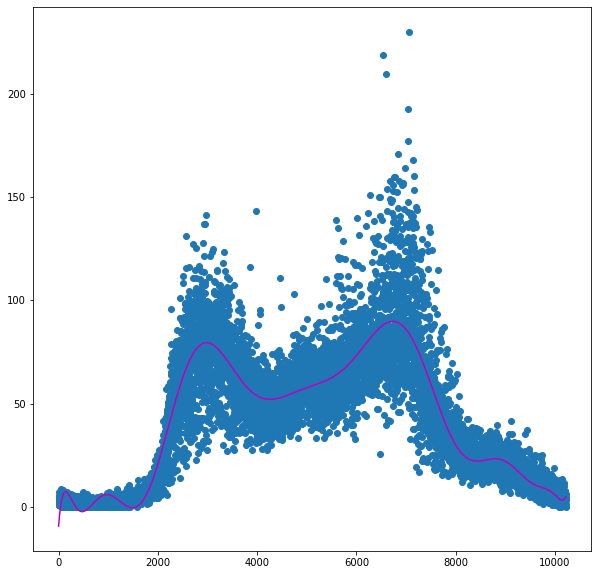

In [11]:
density_y = np.array(densityL)  
density_x = np.array(range(len(densityL)))
plt.scatter(density_x, density_y)
plt.plot(density_model(density_x), color = 'm')
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

In [12]:
print(mb.density_model_r2)

0.8307028059399167


# Optimal speed

In [13]:
optSpeed = mb.optSpeed
optSpeed

88.36363636363636

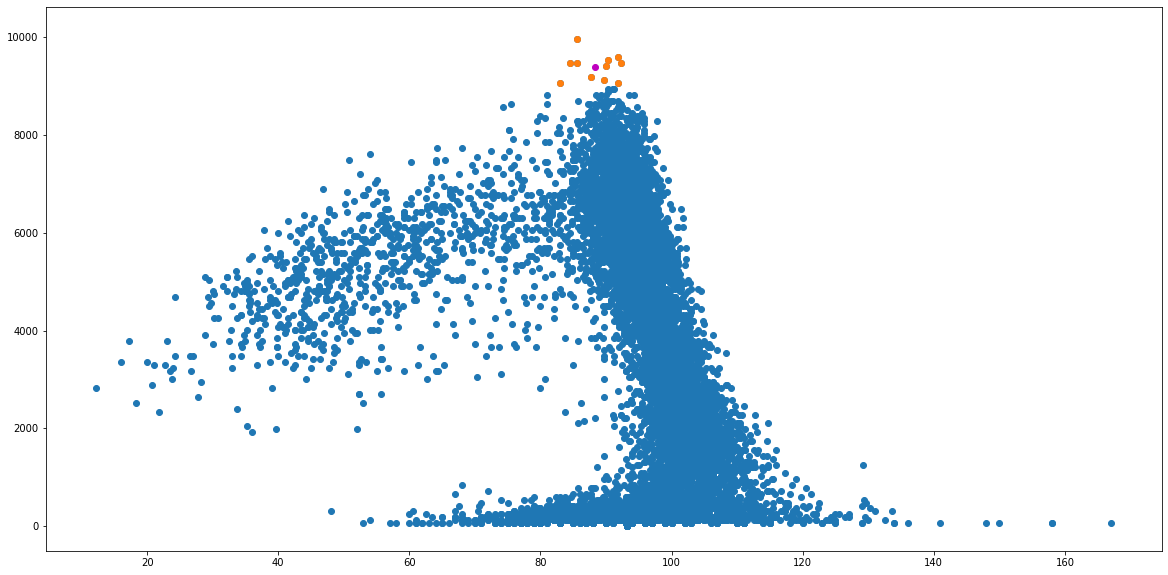

In [14]:
data = pd.concat([flowDF, speedDF], axis = 1, sort = False)
topFlows = data[data[fTag] >= data.quantile(0.999)[0]]
plt.scatter(speedDF[sTag], flowDF[fTag]);
plt.scatter(topFlows[sTag], topFlows[fTag])
plt.scatter(optSpeed, topFlows[fTag].mean(), color = 'm')
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

# Congestion levels

In [15]:
#setting congestion levels by speed
fullLevel = 40
highLevel = 60
midLevel = 80

In [16]:
flowInterval1 = flowDF.quantile(0.25)[0]

In [17]:
def density(q, v):
    return q / v

def densityList(qList, vList):
    d = []
    for i in range(len(qList)):
        if (qList[i] != None and vList[i] != None):
            d.append(density(qList[i], vList[i]))
    return d

In [18]:
#getting congestion details and classifying the periods
lowCongestedPeriods = []
midCongestedPeriods = []
highCongestedPeriods = []
fullCongestedPeriods = []

count = 0
congestedValues = pd.DataFrame(columns = [sTag, fTag])

for index, row in data.iterrows():
    if (row[sTag] < optSpeed and row[fTag] > flowInterval1):
        
        auxDF = pd.DataFrame([[row[sTag], row[fTag]]], columns = [sTag, fTag])
        congestedValues = congestedValues.append(auxDF, ignore_index = True)
        
        if (row[sTag] <= fullLevel):
            fullCongestedPeriods.append(count)
            highCongestedPeriods.append(-1)
            midCongestedPeriods.append(-1)
            lowCongestedPeriods.append(-1)
        elif (row[sTag] <= highLevel):
            highCongestedPeriods.append(count)
            fullCongestedPeriods.append(-1)
            midCongestedPeriods.append(-1)
            lowCongestedPeriods.append(-1)
        elif (row[sTag] <= midLevel):
            midCongestedPeriods.append(count)
            fullCongestedPeriods.append(-1)
            highCongestedPeriods.append(-1)
            lowCongestedPeriods.append(-1)
        else:
            lowCongestedPeriods.append(count)
            fullCongestedPeriods.append(-1)
            highCongestedPeriods.append(-1)
            midCongestedPeriods.append(-1)
 
    else:
        lowCongestedPeriods.append(-1)
        midCongestedPeriods.append(-1)
        highCongestedPeriods.append(-1)
        fullCongestedPeriods.append(-1)
        
    count = count + 1

In [19]:
congestionDensities = []
for index, row in congestedValues.iterrows():
    congestionDensities.append(density(row[fTag], row[sTag]))

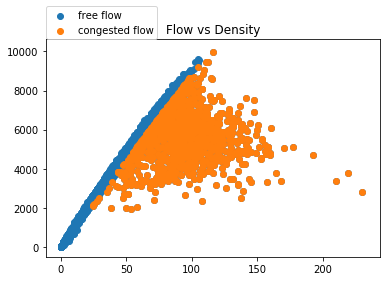

In [20]:
plt.scatter(densityL, flowDF[fTag], label = "free flow")
plt.scatter(congestionDensities, congestedValues[fTag], label = "congested flow")
plt.title("Flow vs Density")
plt.legend(loc=(0,1))

In [21]:
lowCongestionDensities = []
lowCongestionFlows = []
midCongestionDensities = []
midCongestionFlows = []
highCongestionDensities = []
highCongestionFlows = []
fullCongestionDensities = []
fullCongestionFlows = []

for index, row in congestedValues.iterrows():
    
    if (row[sTag] <= fullLevel):
        fullCongestionDensities.append(density(row[fTag], row[sTag]))
        fullCongestionFlows.append(row[fTag])
    elif (row[sTag] <= highLevel):
        highCongestionDensities.append(density(row[fTag], row[sTag]))
        highCongestionFlows.append(row[fTag])
    elif (row[sTag] <= midLevel):
        midCongestionDensities.append(density(row[fTag], row[sTag]))
        midCongestionFlows.append(row[fTag])
    else: 
        lowCongestionDensities.append(density(row[fTag], row[sTag]))
        lowCongestionFlows.append(row[fTag])


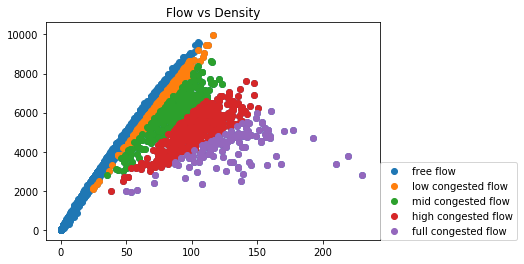

In [22]:
plt.scatter(densityL, flowDF[fTag], label = "free flow")
plt.scatter(lowCongestionDensities, lowCongestionFlows, label = "low congested flow")
plt.scatter(midCongestionDensities, midCongestionFlows, label = "mid congested flow")
plt.scatter(highCongestionDensities, highCongestionFlows, label = "high congested flow")
plt.scatter(fullCongestionDensities, fullCongestionFlows, label = "full congested flow")
plt.title("Flow vs Density")
plt.legend(loc=(1,0))

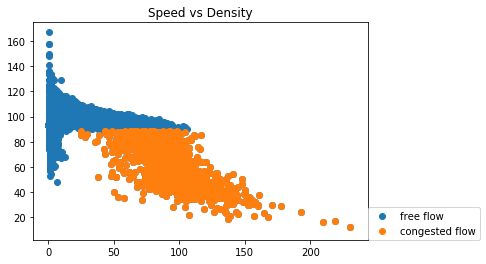

In [23]:
plt.scatter(densityL, speedDF[sTag], label = "free flow")
plt.scatter(congestionDensities, congestedValues[sTag], label = "congested flow")
plt.title("Speed vs Density")
plt.legend(loc=(1,0))

In [24]:
congestionSpeeds = []
for index, row in congestedValues.iterrows():
    congestionSpeeds.append(row[sTag])
    

Text(0.5, 1.0, 'Congestion speeds histogram')

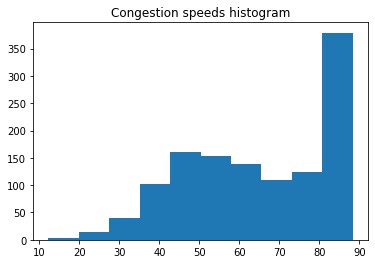

In [25]:
plt.hist(congestionSpeeds)
plt.title("Congestion speeds histogram")

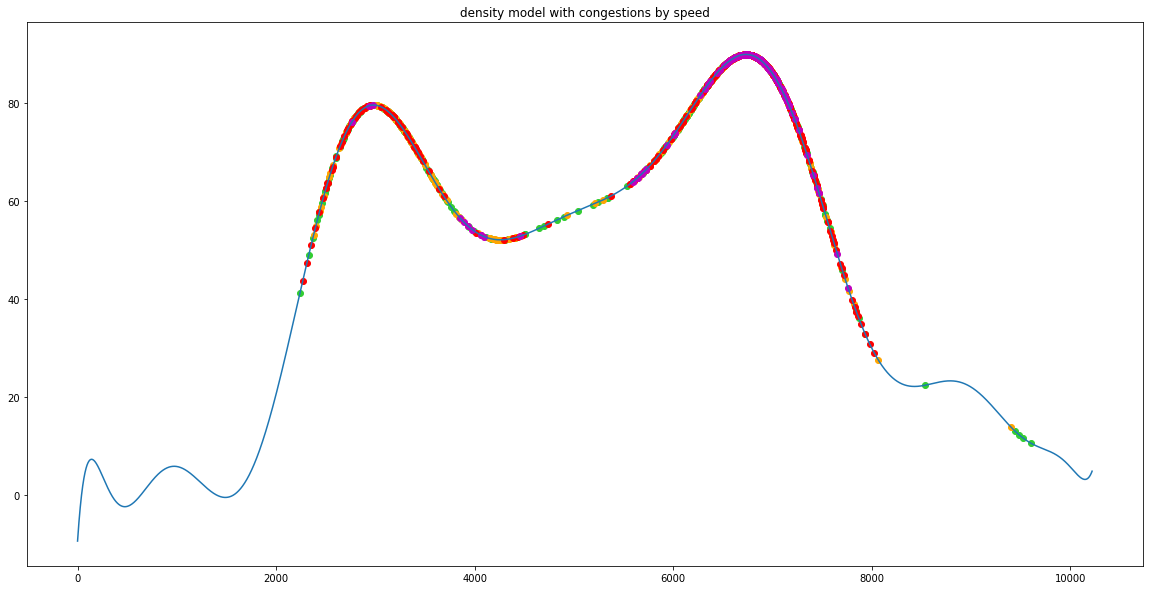

In [26]:
threshold = 10
low_y_values = np.ma.array(density_model(lowCongestedPeriods))
mid_y_values = np.ma.array(density_model(midCongestedPeriods))
high_y_values = np.ma.array(density_model(highCongestedPeriods))
full_y_values = np.ma.array(density_model(fullCongestedPeriods))

low_y_values_masked = np.ma.masked_where(low_y_values < threshold , low_y_values)
mid_y_values_masked = np.ma.masked_where(mid_y_values < threshold , mid_y_values)
high_y_values_masked = np.ma.masked_where(high_y_values < threshold , high_y_values)
full_y_values_masked = np.ma.masked_where(full_y_values < threshold , full_y_values)

plt.plot(density_model(density_x))
plt.scatter(range(len(lowCongestedPeriods)), low_y_values_masked, color = 'limegreen')
plt.scatter(range(len(midCongestedPeriods)), mid_y_values_masked, color = 'orange')
plt.scatter(range(len(highCongestedPeriods)), high_y_values_masked, color = 'r')
plt.scatter(range(len(fullCongestedPeriods)), full_y_values_masked, color = 'm')
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.title("density model with congestions by speed")
plt.show()

# Flow speed model

In [27]:
flow_speed_model = mb.flow_speed_model
flow_speed_model_r2 = mb.flow_speed_model_r2

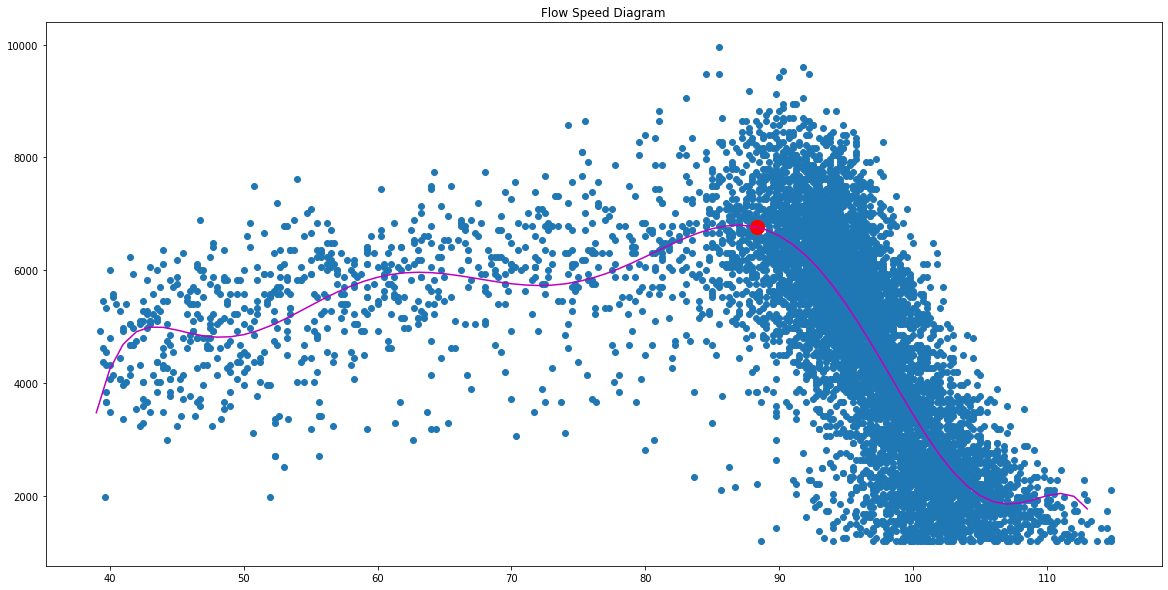

In [28]:
selData = data[(data[sTag] < speedDF.quantile(0.99)[0]) & (data[sTag] > speedDF.quantile(0.01)[0]) & (data[fTag] > flowDF.quantile(0.25)[0])]
sel_flow = np.array(selData.iloc[:, 1])
sel_speed = np.array(selData.iloc[:, 3])
plt.scatter(sel_speed, sel_flow)
plt.plot(range(int(min(sel_speed)), int(max(sel_speed))), flow_speed_model(range(int(min(sel_speed)), int(max(sel_speed)))), color = 'm')
plt.scatter(optSpeed, flow_speed_model(optSpeed), s = 200, color = 'r')
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.title("Flow Speed Diagram")
plt.show()

In [29]:
print(flow_speed_model_r2)

0.6211130199642885


In [30]:
optDer = 10
optXs = []
for i in range(int(min(sel_speed)), int(max(sel_speed))):
    der = derivative(flow_speed_model, i, dx=1e-6)
    if (der < 0):
        der = der * -1
    if (der < optDer):
        optXs.append(i)
print(optXs)

[48, 63, 72, 87, 107, 111]


# Flow density model

In [31]:
flow_density_model = mb.flow_density_model
flow_density_model_r2 = mb.flow_density_model_r2

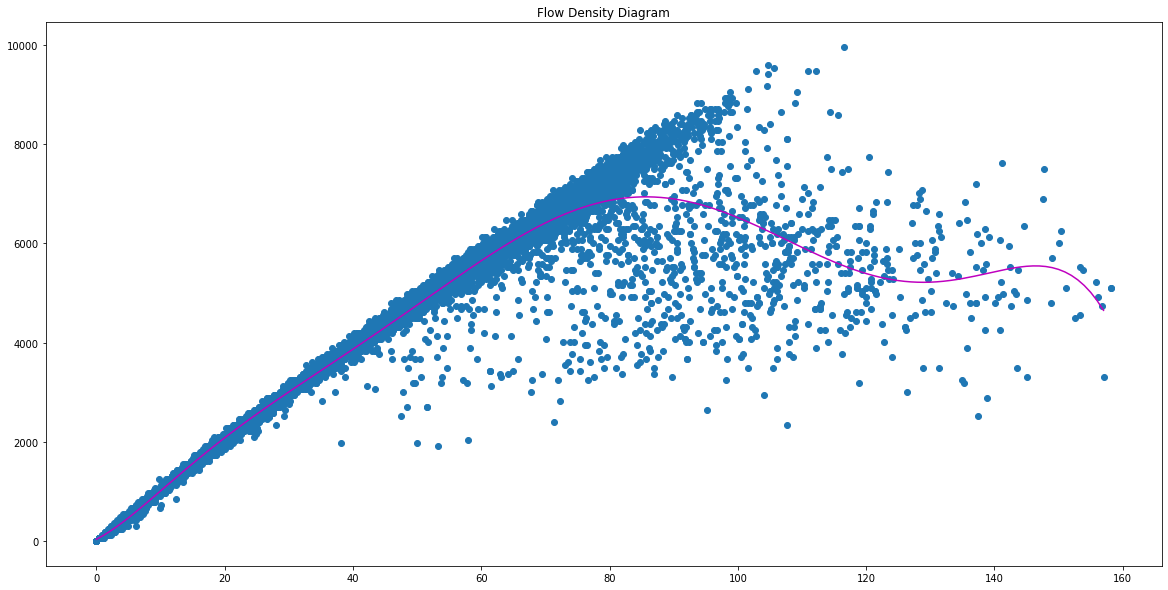

In [32]:
sel_density = densityList(flowDF[fTag], speedDF[sTag])
fdDF = pd.DataFrame(columns = [kTag, fTag])
for index, row in flowDF.iterrows():
    if (sel_density[index] < np.percentile(sel_density, 99.9)):
        auxDF = pd.DataFrame([[sel_density[index], row[fTag]]], columns = [kTag, fTag])
        fdDF = fdDF.append(auxDF, ignore_index = True)

plt.scatter(fdDF[kTag], fdDF[fTag])
plt.plot(range(int(min(fdDF[kTag])), int(max(fdDF[kTag]))), flow_density_model(range(int(min(fdDF[kTag])), int(max(fdDF[kTag])))), color = 'm')
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.title("Flow Density Diagram")
plt.show()

In [33]:
print(flow_density_model_r2)

0.9575126600428259


In [34]:
criticalDensity = mb.criticalDensity
print("critical density: " + str(criticalDensity))

critical density: 84


# Speed density model

In [35]:
speed_density_model = mb.speed_density_model
speed_density_model_r2 = mb.speed_density_model_r2

In [36]:
sel_density = densityList(flowDF[fTag], speedDF[sTag])
sdDF = pd.DataFrame(columns = [kTag, sTag])
for index, row in speedDF.iterrows():
    if (sel_density[index] < np.percentile(sel_density, 99.9) and sel_density[index] > np.percentile(sel_density, 25)):
        auxDF = pd.DataFrame([[sel_density[index], row[sTag]]], columns = [kTag, sTag])
        sdDF = sdDF.append(auxDF, ignore_index = True)

densityAtOptSpeed = speed_density_model(int(min(sdDF[kTag])))
minDistance = optSpeed - speed_density_model(int(min(sdDF[kTag])))
if (minDistance < 0):
    minDistance = minDistance * -1

for i in range(int(min(sdDF[kTag])) + 1, int(max(sdDF[kTag]))):
    auxDistance = optSpeed - speed_density_model(i)
    if (auxDistance < 0):
        auxDistance = auxDistance * -1
    if (auxDistance < minDistance):
        minDistance = auxDistance
        densityAtOptSpeed = i

print("density at optimal speed: " + str(densityAtOptSpeed))

density at optimal speed: 77


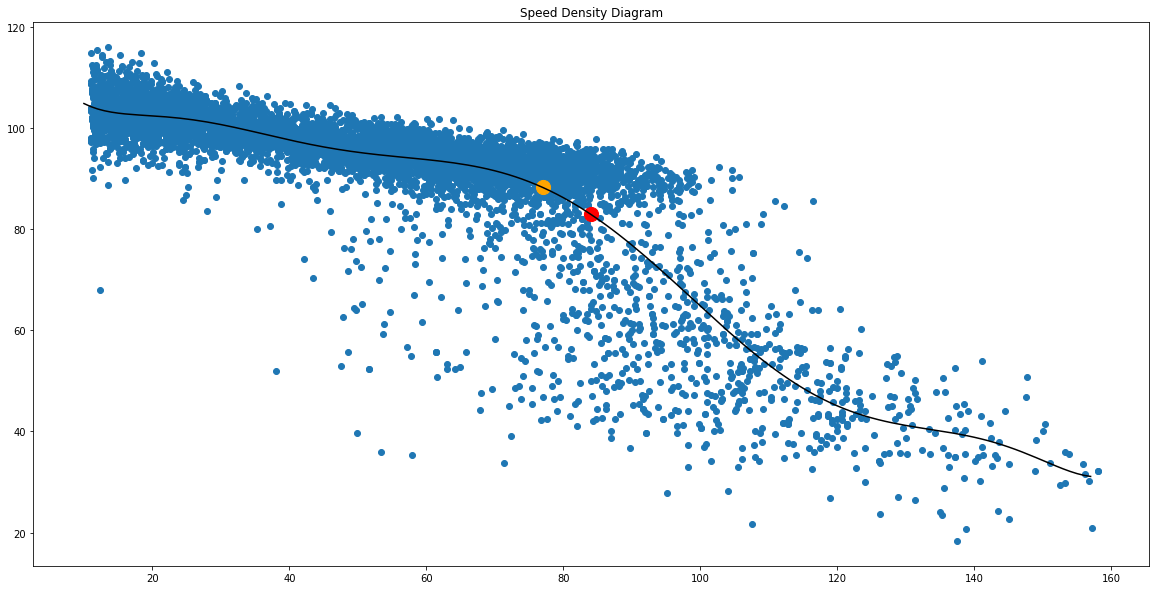

In [37]:
plt.scatter(sdDF[kTag], sdDF[sTag])
plt.plot(range(int(min(sdDF[kTag])), int(max(sdDF[kTag]))), speed_density_model(range(int(min(sdDF[kTag])), int(max(sdDF[kTag])))), color = 'black')
plt.scatter(densityAtOptSpeed, optSpeed, s = 200, color = 'orange')
plt.scatter(criticalDensity, speed_density_model(criticalDensity), s = 200, color = 'r')
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.title("Speed Density Diagram")
plt.show()

In [38]:
print(flow_speed_model_r2)

0.6211130199642885


In [39]:
print("speed at critical density: " + str(speed_density_model(criticalDensity)) + ", optimal speed: " + str(optSpeed))

speed at critical density: 82.92964350325968, optimal speed: 88.36363636363636


# Critical density limit reached

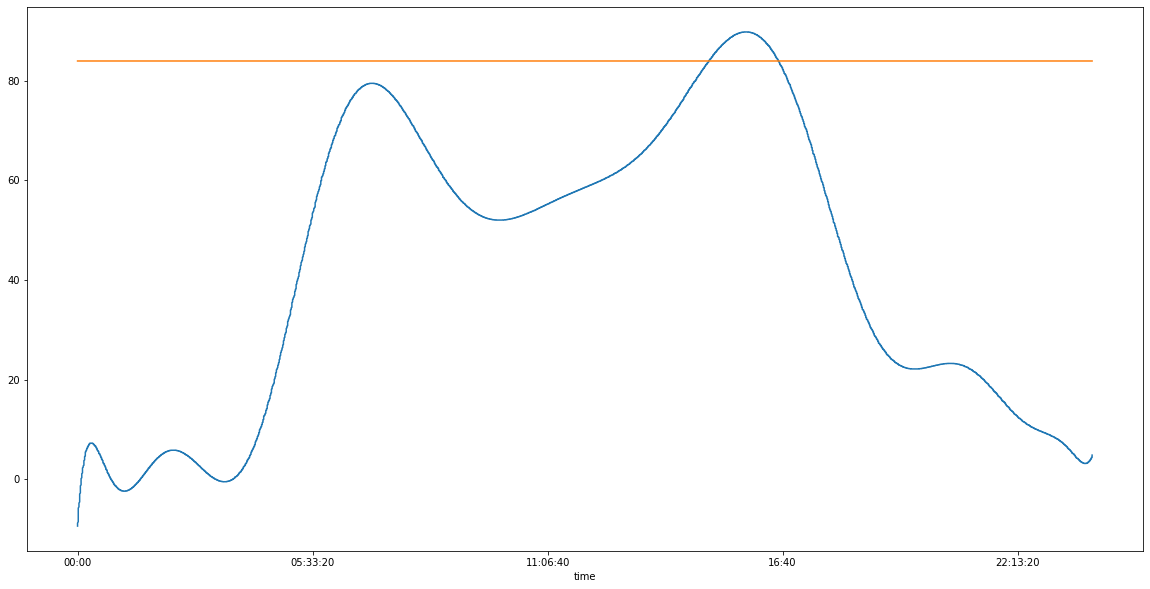

In [40]:
density_x = np.array(range(len(densityL)))
kc_list = []
for i in range(len(density_x)):
    kc_list.append(criticalDensity)
plt.plot(flowDF[dTag], density_model(density_x))
plt.plot(flowDF[dTag], kc_list)
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

In [41]:
congestedTime = []
count = 0
for i in kc_list:
    
    if (density_model(count) > criticalDensity):
        congestedTime.append(count)
    
    count += 1

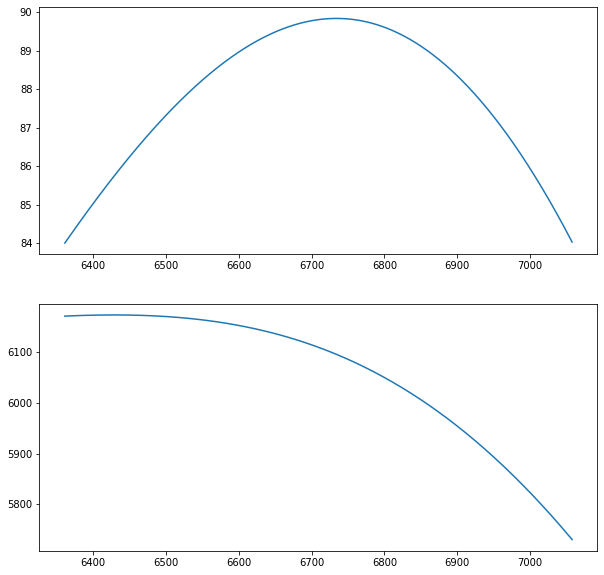

In [42]:
plt.subplot(211)
plt.plot(congestedTime, density_model(congestedTime))
plt.subplot(212)
plt.plot(congestedTime, flow_model(congestedTime))
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

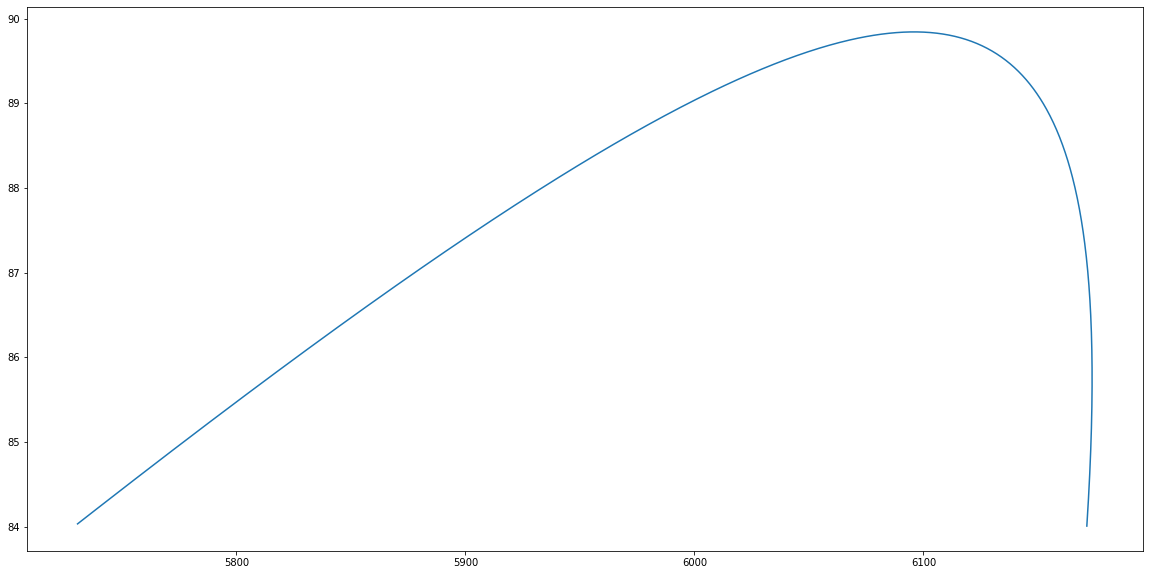

In [43]:
#by combinig the functions above
plt.plot(flow_model(congestedTime), density_model(congestedTime))
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

In [44]:
total_vehicles = quad(density_model, min(congestedTime), max(congestedTime)) 
kc_model = interp1d(range(len(kc_list)), kc_list)
under_kc_vehicles = quad(kc_model, min(congestedTime), max(congestedTime)) 
vehicles_exces = total_vehicles[0] - under_kc_vehicles[0]
print(vehicles_exces)

2679.7208115449466


In [45]:
# transform to a day scale
(vehicles_exces*248) / count # 248 measures per day

65.02013122621531

# Speeds by level plotted in density model (day data)

In [46]:
def showDensityModelWithSpeeds(start_date, end_date):
    day_A_data = rawData[(rawData[dTag] > start_date) & (rawData[dTag] < end_date)]
    ratio = flowDF.shape[0] / day_A_data.shape[0]
    
    lowCongestedPeriods_dayA = []
    midCongestedPeriods_dayA = []
    highCongestedPeriods_dayA = []
    fullCongestedPeriods_dayA = []

    count = 0
    i_exp = 0
    k = 0
    
    # selecting periods
    for key, value in rawData.iterrows():

        if (day_A_data.iloc[[i_exp][0]][sTag] <= optSpeed and day_A_data.iloc[[i_exp][0]][sTag] > midLevel and day_A_data.iloc[[i_exp][0]][fTag] > flowInterval1):
            lowCongestedPeriods_dayA.append(k)
            midCongestedPeriods_dayA.append(-1)
            highCongestedPeriods_dayA.append(-1)
            fullCongestedPeriods_dayA.append(-1)
        elif (day_A_data.iloc[[i_exp][0]][sTag] <= midLevel and day_A_data.iloc[[i_exp][0]][sTag] > highLevel and day_A_data.iloc[[i_exp][0]][fTag] > flowInterval1):
            midCongestedPeriods_dayA.append(k)
            lowCongestedPeriods_dayA.append(-1)
            highCongestedPeriods_dayA.append(-1)
            fullCongestedPeriods_dayA.append(-1)
        elif (day_A_data.iloc[[i_exp][0]][sTag] <= highLevel and day_A_data.iloc[[i_exp][0]][sTag] > fullLevel and day_A_data.iloc[[i_exp][0]][fTag] > flowInterval1):
            highCongestedPeriods_dayA.append(k)
            lowCongestedPeriods_dayA.append(-1)
            midCongestedPeriods_dayA.append(-1)
            fullCongestedPeriods_dayA.append(-1)
        elif (day_A_data.iloc[[i_exp][0]][sTag] <= highLevel and day_A_data.iloc[[i_exp][0]][fTag] > flowInterval1):
            fullCongestedPeriods_dayA.append(k)
            lowCongestedPeriods_dayA.append(-1)
            midCongestedPeriods_dayA.append(-1)
            highCongestedPeriods_dayA.append(-1)
        else:
            lowCongestedPeriods_dayA.append(-1)
            midCongestedPeriods_dayA.append(-1)
            highCongestedPeriods_dayA.append(-1)
            fullCongestedPeriods_dayA.append(-1)

        if (count > ratio):
            count = 0
            i_exp += 1

        count += 1
        k += 1
        
        threshold = 1
    
    # plotting the results
    lowCongestedArr_dayA = np.ma.array(density_model(lowCongestedPeriods_dayA))
    lowCongestedMasked_dayA = np.ma.masked_where(lowCongestedArr_dayA <= threshold , lowCongestedArr_dayA)

    midCongestedArr_dayA = np.ma.array(density_model(midCongestedPeriods_dayA))
    midCongestedMasked_dayA = np.ma.masked_where(midCongestedArr_dayA <= threshold , midCongestedArr_dayA)

    highCongestedArr_dayA = np.ma.array(density_model(highCongestedPeriods_dayA))
    highCongestedMasked_dayA = np.ma.masked_where(highCongestedArr_dayA <= threshold , highCongestedArr_dayA)

    fullCongestedArr_dayA = np.ma.array(density_model(fullCongestedPeriods_dayA))
    fullCongestedMasked_dayA = np.ma.masked_where(fullCongestedArr_dayA <= threshold , fullCongestedArr_dayA)

    plt.plot(density_model(range(len(flowDF))))
    plt.scatter(range(len(lowCongestedMasked_dayA)), lowCongestedMasked_dayA, color = "green", label = "low congested")
    plt.scatter(range(len(midCongestedMasked_dayA)), midCongestedMasked_dayA, color = "orange", label = "mid congested")
    plt.scatter(range(len(highCongestedMasked_dayA)), highCongestedMasked_dayA, color = "red", label = "high congested")
    plt.scatter(range(len(fullCongestedMasked_dayA)), fullCongestedMasked_dayA, color = "black", label = "full congested")
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    plt.legend(loc=(1,0))
    plt.show()

In [47]:
def showDensityAndKC(dt_a, dt_b):
    day_A_data = rawData[rawData[dTag] > dt_a]
    day_A_data = day_A_data[rawData[dTag] < dt_b]
    day_A_data = day_A_data.reset_index()
    kc_list_dayA = []
    for i in range(day_A_data.shape[0]):
        kc_list_dayA.append(criticalDensity)
    plt.plot(density(day_A_data[fTag], day_A_data[sTag]))
    plt.plot(kc_list_dayA)
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    plt.legend(loc=(1,0))
    plt.show()

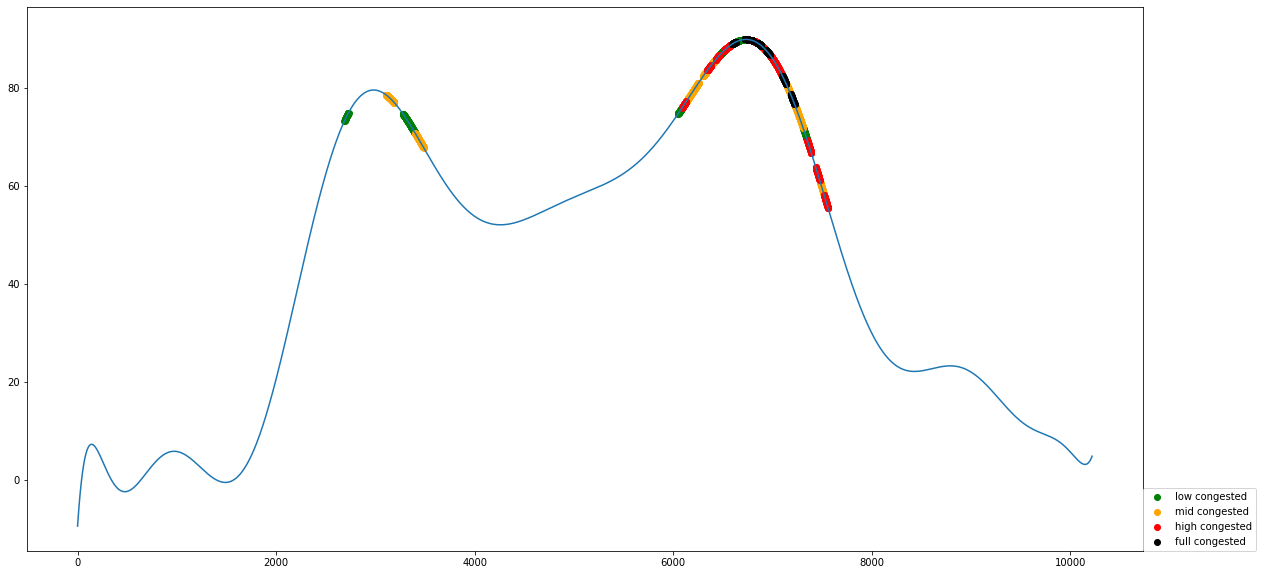

/home/oem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.


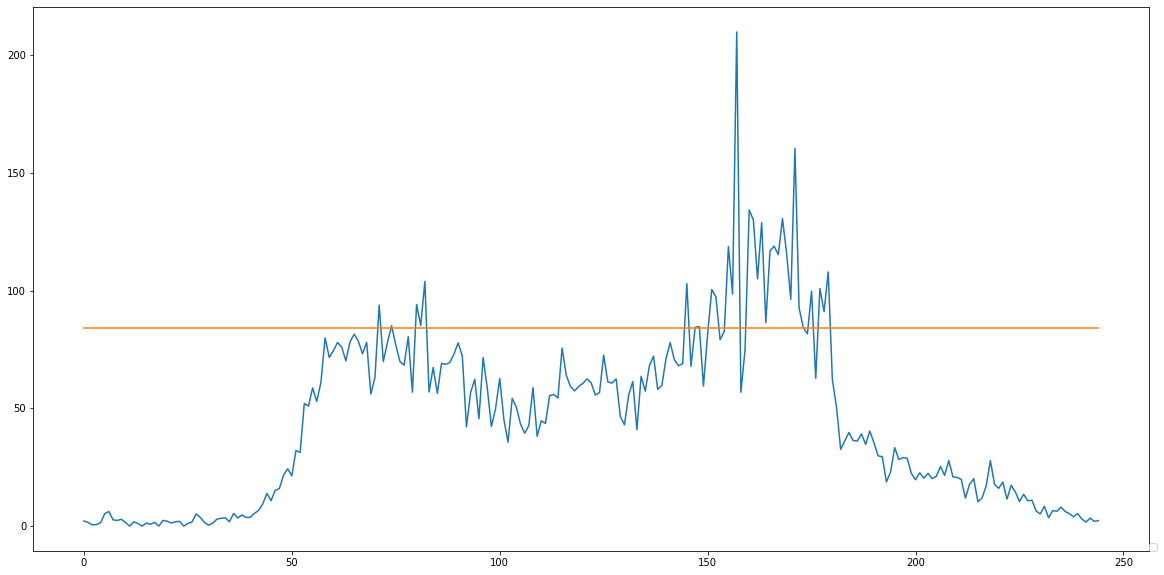

In [48]:
dt_a = '2020-02-04 00:00:00.000'
dt_b = '2020-02-05 00:00:00.000'
showDensityModelWithSpeeds(dt_a, dt_b)
showDensityAndKC(dt_a, dt_b)

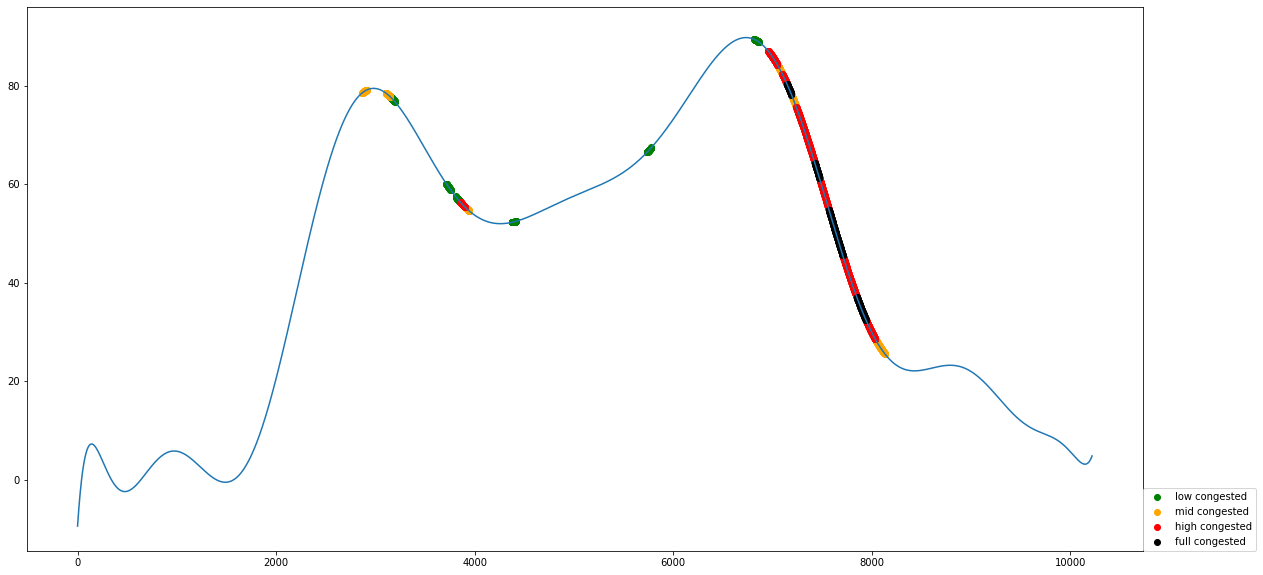

No handles with labels found to put in legend.


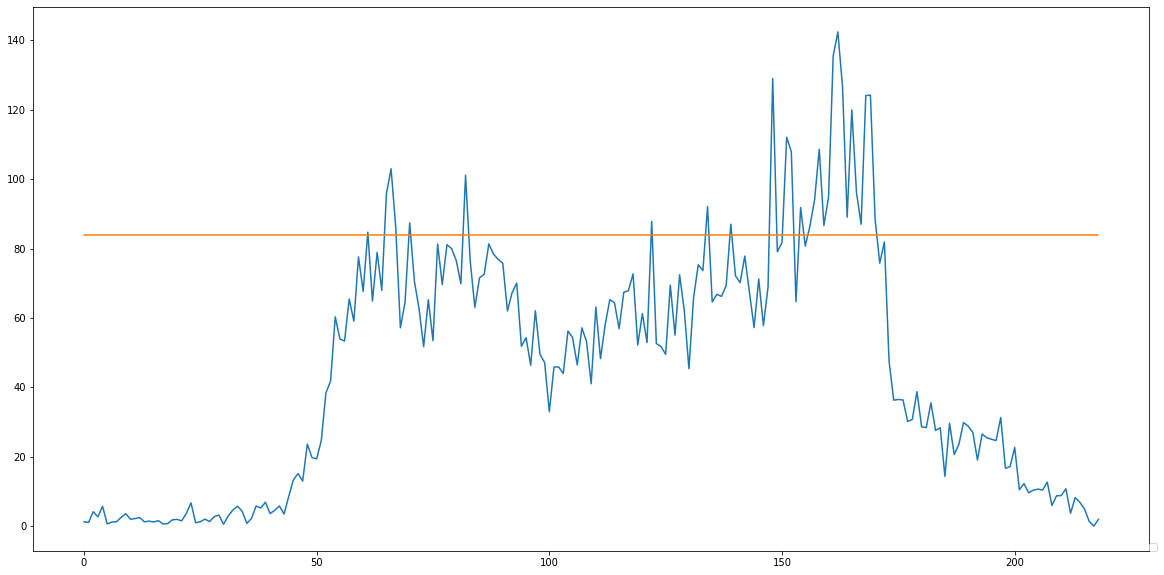

In [49]:
dt_a = '2019-11-26 00:00:00.0'
dt_b = '2019-11-27 00:00:00.0'
showDensityModelWithSpeeds(dt_a, dt_b)
showDensityAndKC(dt_a, dt_b)

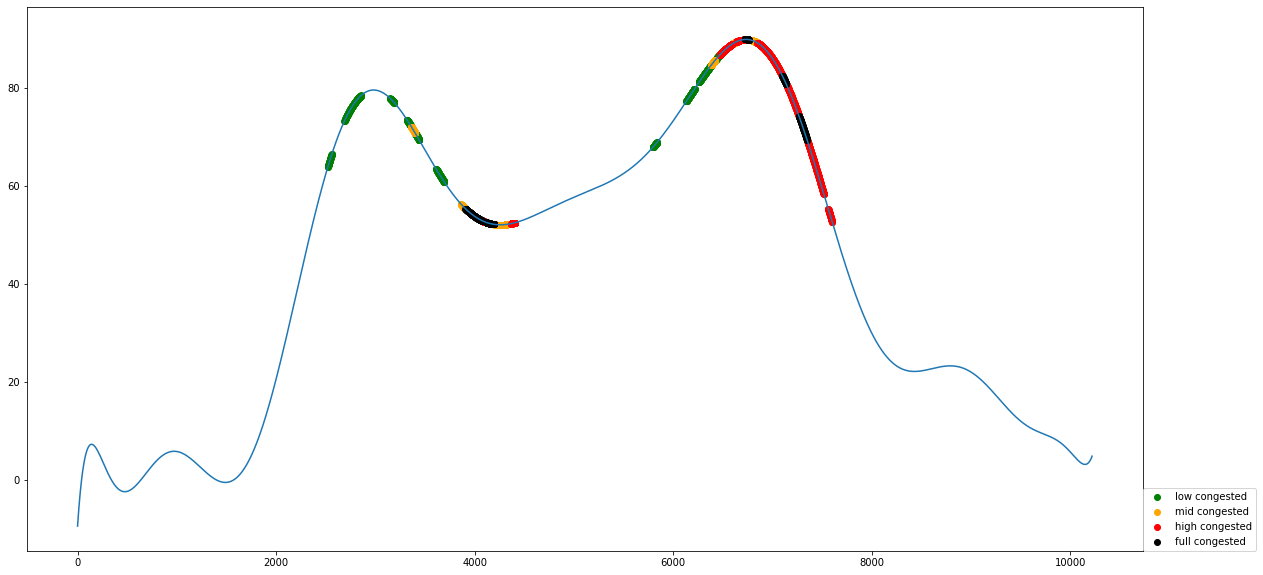

/home/oem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.


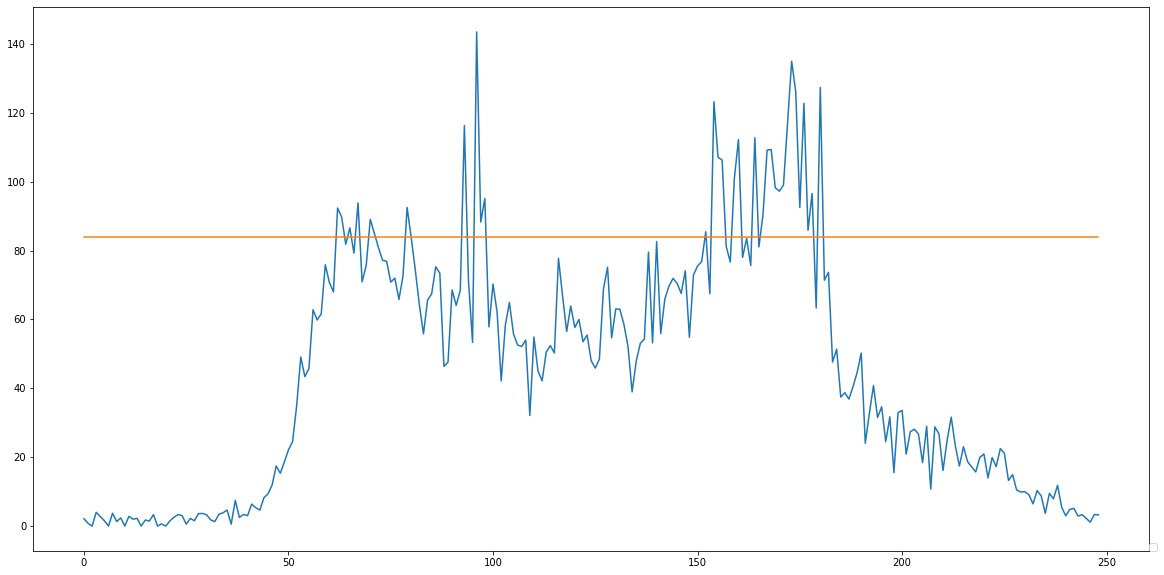

In [50]:
dt_a = '2019-12-04 00:00:00.0'
dt_b = '2019-12-05 00:00:00.0'
showDensityModelWithSpeeds(dt_a, dt_b)
showDensityAndKC(dt_a, dt_b)

# Spacing analysis

## Speed model

In [51]:
fitDegree = 16
speed_y = np.array(speedDF.iloc[:, 1])
speed_x = np.array(range(len(speedDF)))
speed_coefs = np.polyfit(speed_x, speed_y, fitDegree)
speed_model = np.poly1d(speed_coefs)
speed_model_r2 = r2_score(speed_y, speed_model(speed_x))

/home/oem/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


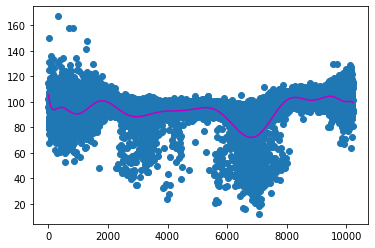

In [52]:
plt.scatter(range(speedDF.shape[0]), speedDF[sTag])
plt.plot(speed_model(range(speedDF.shape[0])), color = "m")

In [53]:
cong_start_time = None
cong_end_time = None

for index, row in flowDF.iterrows():
    if (index == min(congestedTime)):
        cong_start_time = row[dTag]
    if (index == max(congestedTime)):
        cong_end_time = row[dTag]
        
print(cong_start_time)
print(cong_end_time) # !!!!! one hour after because of the winter time

14:55:00
16:34:00


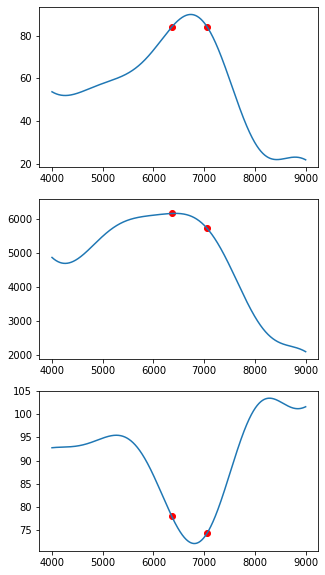

In [54]:
rng = range(4000,9000)
plt.subplot(311)
plt.plot(rng, density_model(rng))
plt.scatter(min(congestedTime), density_model(min(congestedTime)), color = 'r')
plt.scatter(max(congestedTime), density_model(max(congestedTime)), color = 'r')
plt.subplot(312)
plt.plot(rng, flow_model(rng))
plt.scatter(min(congestedTime), flow_model(min(congestedTime)), color = 'r')
plt.scatter(max(congestedTime), flow_model(max(congestedTime)), color = 'r')
plt.subplot(313)
plt.plot(rng, speed_model(rng))
plt.scatter(min(congestedTime), speed_model(min(congestedTime)), color = 'r')
plt.scatter(max(congestedTime), speed_model(max(congestedTime)), color = 'r')
fig = plt.gcf()
fig.set_size_inches(5, 10)
plt.show()

# Spacing model

In [55]:
def spacing(t):
    k = density_model(t)
    k = k / 1000 # convert to meters
    s = 1/k
    return s


In [56]:
reaction_time = 1 # seconds

def securityDistance(t):
    v = speed_model(t)
    v = v / 3600 # convert to seconds
    x = v * reaction_time
    x = x * 1000 # convert to meters
    return x
    

In [57]:
below_first = -1
below_sec = -1

for index in range(speedDF.shape[0]):
    if (spacing(index) < securityDistance(index)):
        if (below_first < 0):
            below_first = index
        else:
            below_sec = index

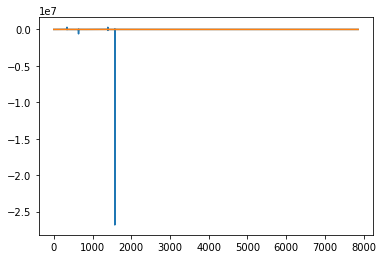

In [58]:
plt.plot(spacing(range(below_first, below_sec)))
plt.plot(securityDistance(range(below_first, below_sec)))